In [1]:
import numpy as np
import pandas as pd

### Data Preprcessing

In [2]:
mks = pd.read_csv("data/MKS.csv")

In [3]:
#data preprocessing 
#remove NaN values
nans = mks[mks['Close'].isnull()]
mks.drop(nans.index, inplace=True) 

### Create Features Dataframes

In [4]:
# Initialize a data frames to hold the Features and the value
X_len = 940
days = 10

Χ_columns = []
for j in range(days):
    Χ_columns.append('i+%s' % str(j))
    
X = pd.DataFrame(index=range(X_len),columns = Χ_columns)
y = pd.DataFrame(index=range(X_len), columns = ['Close'])

    
for i in range(X_len):
    for j in range(days):
        X.iloc[i]['i+%s' % str(j)] = mks.iloc[i + j]['Close']
    y.iloc[i] = mks.iloc[(i + j + 1)]['Close']
    
v = pd.concat([X, y], axis=1)
v.head()

,i+0,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9,Close
0,459.8,469.9,471.6,461.9,452.9,453.3,456,442,435.5,426.7,416.6
1,469.9,471.6,461.9,452.9,453.3,456,442,435.5,426.7,416.6,427.7
2,471.6,461.9,452.9,453.3,456,442,435.5,426.7,416.6,427.7,434.5
3,461.9,452.9,453.3,456,442,435.5,426.7,416.6,427.7,434.5,442.3
4,452.9,453.3,456,442,435.5,426.7,416.6,427.7,434.5,442.3,440.2


### Calculate squared daily deviation 

In [5]:
#Calculate squared daily deviation
dv = pd.DataFrame(index=range(X_len), columns = ['dv'])
dv.iloc[0] = 0
for i in range(1, X_len):
    dv.iloc[i] = mks.iloc[i]['Close'] - mks.iloc[i - 1]['Close']    
dv = np.sqrt((dv ** 2).mean())
dv

dv    6.778292
dtype: float64

### Split train/test set

In [6]:
def split_train_test_set(X, y, test_size=0.2):  
    if len(X) != len(y):
        return "Error"
    split_index = int(len(X) * (1-test_size))
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

### Create cross validation folds

In [7]:
def create_cv_sets(n_splits, size):
    cv_sets = []
    for index in range(n_splits):
        X_train, X_test, y_train, y_test = split_train_test_set(X[index:index + size], y[index:index + size])    
        cv_sets.append([X_train, X_test, y_train, y_test])
    return cv_sets 

### Define metrics and print metrics

In [8]:
# Import metrics, Crete custom metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

def rmsp(test, pred):
    return np.sqrt(np.mean(((test - pred)/test)**2)) * 100

def rmse(test, pred):
    return np.sqrt(((test - pred) ** 2).mean())

def print_metrics(test, pred):
    print('RMSE %f'%  rmse(test, pred))
    print('Root Mean Squared Percentage Error %f'% rmsp(test, pred))
    print('Mean Absolute Error: %f'% mean_absolute_error(test, pred))
    print('Explained Variance Score: %f'% explained_variance_score(test, pred))
    print('Mean Squared Error: %f'% mean_squared_error(test, pred))
    print('R2 score: %f'% r2_score(test, pred))
    print('')

In [9]:
n_splits = 3
size =310

cv_sets = create_cv_sets(n_splits, size)

### Train and Tune Linear Regressor

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

def get_lr_model(X, y):
    regressor = LinearRegression()
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
    grid = GridSearchCV(regressor, parameters)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Iterate through cross validation sets, calc errors, print metrics

In [11]:
#Iterate through cv_sets, calc errors, print metrics
lr_regs = []
lr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    lr_reg = get_lr_model(X_train, y_train)
    lr_regs.append(lr_reg)
    pred = lr_reg.predict(X_test)
    lr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)

RMSE 6.655403
Root Mean Squared Percentage Error 1.197290
Mean Absolute Error: 4.951782
Explained Variance Score: 0.833893
Mean Squared Error: 44.294394
R2 score: 0.826694

RMSE 6.700743
Root Mean Squared Percentage Error 1.206829
Mean Absolute Error: 4.991199
Explained Variance Score: 0.847973
Mean Squared Error: 44.899962
R2 score: 0.838626

RMSE 6.903192
Root Mean Squared Percentage Error 1.245639
Mean Absolute Error: 5.106675
Explained Variance Score: 0.837908
Mean Squared Error: 47.654056
R2 score: 0.832988



In [12]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

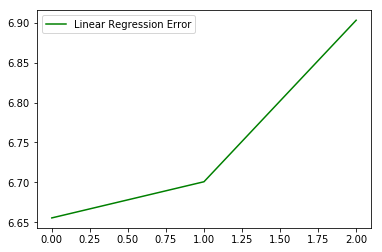

In [13]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.legend()
plt.show()

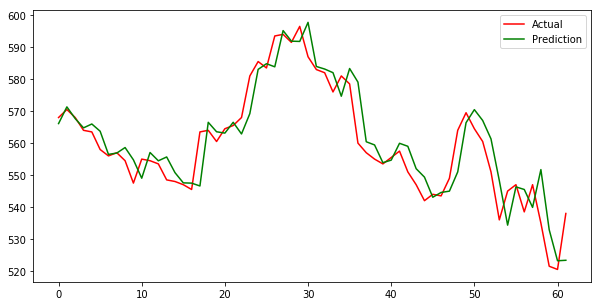

In [14]:
rcParams['figure.figsize'] = 10,5
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, lr_regs[n_splits - 1].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [15]:
lr_regs[0].coef_

array([[ 0.07785975, -0.02334136, -0.02546941, -0.032437  ,  0.17441355,
        -0.15248721, -0.11303175,  0.13307402, -0.10096956,  1.06377671]])

In [16]:
from sklearn.linear_model import Ridge 

def get_ridge_model(X_train, X_test, y_train, y_test):
    r_reg = Ridge()
    r_reg.fit(X_train, y_train)
    return r_reg

In [17]:
#Iterate through cv_sets, calc errors, print metrics
rr_regs=[]
rr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    rr_reg = get_ridge_model(X_train,X_test,y_train,y_test)
    pred = rr_reg.predict(X_test)
    rr_regs.append(rr_reg)
    rr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)    

RMSE 6.860203
Root Mean Squared Percentage Error 1.235944
Mean Absolute Error: 5.246640
Explained Variance Score: 0.832478
Mean Squared Error: 47.062381
R2 score: 0.815864

RMSE 7.016969
Root Mean Squared Percentage Error 1.266062
Mean Absolute Error: 5.436225
Explained Variance Score: 0.846488
Mean Squared Error: 49.237851
R2 score: 0.823035

RMSE 7.080446
Root Mean Squared Percentage Error 1.278938
Mean Absolute Error: 5.382244
Explained Variance Score: 0.836792
Mean Squared Error: 50.132723
R2 score: 0.824301



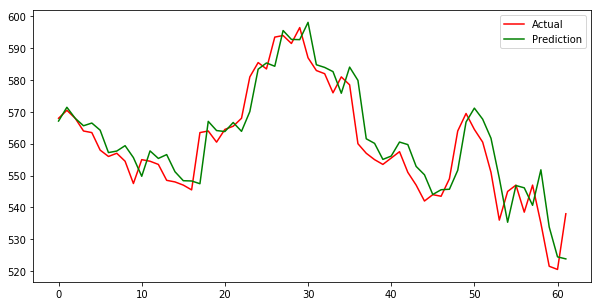

In [18]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, rr_regs[0].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [19]:
rr_regs[1].coef_

array([[ 0.07926718, -0.01637378, -0.02187429, -0.02902184,  0.16766987,
        -0.17070296, -0.08730867,  0.13424622, -0.10518672,  1.05964239]])

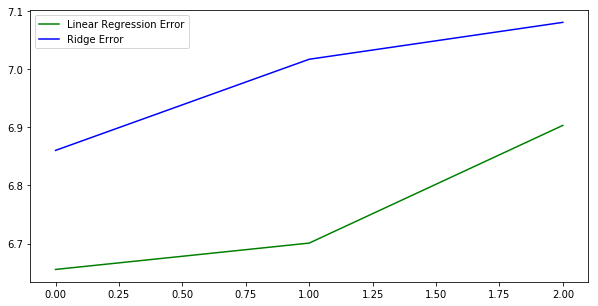

In [20]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.legend()
plt.show()

In [21]:
from sklearn.svm import LinearSVR
def lsvr(X_train, X_test, y_train, y_test):
    svr = LinearSVR()
    svr.fit(X_train, y_train.values.ravel())
    return svr

In [22]:
#Iterate through cv_sets, calc errors, print metrics
svrs=[]
svr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets: 
    svr = lsvr(X_train, X_test, y_train, y_test)
    svrs.append(svr)
    pred = svr.predict(X_test)
    svr_errs.append(rmse(y_test.values.ravel(), pred)) 
    print_metrics(y_test.values.ravel(), pred)


RMSE 23.976204
Root Mean Squared Percentage Error 4.301251
Mean Absolute Error: 23.017119
Explained Variance Score: 0.823657
Mean Squared Error: 574.858337
R2 score: -1.249186

RMSE 12.534851
Root Mean Squared Percentage Error 2.261293
Mean Absolute Error: 11.218214
Explained Variance Score: 0.844701
Mean Squared Error: 157.122486
R2 score: 0.435288

RMSE 6.936051
Root Mean Squared Percentage Error 1.245151
Mean Absolute Error: 5.006271
Explained Variance Score: 0.835495
Mean Squared Error: 48.108798
R2 score: 0.831395



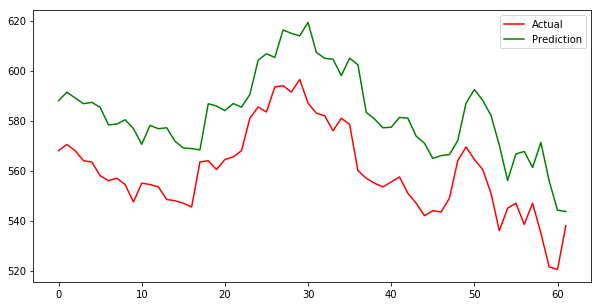

In [23]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, svrs[0].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

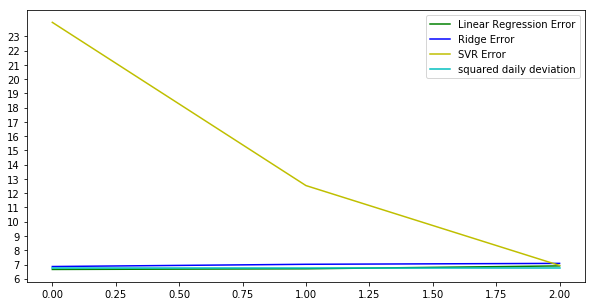

In [24]:
rcParams['figure.figsize'] = 10,5
dvl = [dv]* n_splits
t = range(n_splits)
plt.yticks(np.arange(0, max(svr_errs)))
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.plot(t, svr_errs, 'y', label='SVR Error')
plt.plot(t, dvl, 'c', label='squared daily deviation')
plt.legend()
plt.show()

In [25]:
last = np.array([310.5,312.5, 313.5,316.200012,316.299988,314.799988,316.100006,320.5,308.79998,308.700012]).reshape(1,-1)
pred = lr_regs[0].predict(last)
pred

array([[309.93344382]])

In [26]:
last = np.array([316.200012, 316.299988,314.799988,316.100006,320.5,308.799988,313.700012,310.80,318.30,324.00]).reshape(1,-1)
pred = lr_regs[0].predict(last)
pred


array([[326.20316029]])

In [27]:
from sklearn.externals import joblib
joblib.dump(lr_regs[0], 'prediction_model.pkl') 

['prediction_model.pkl']